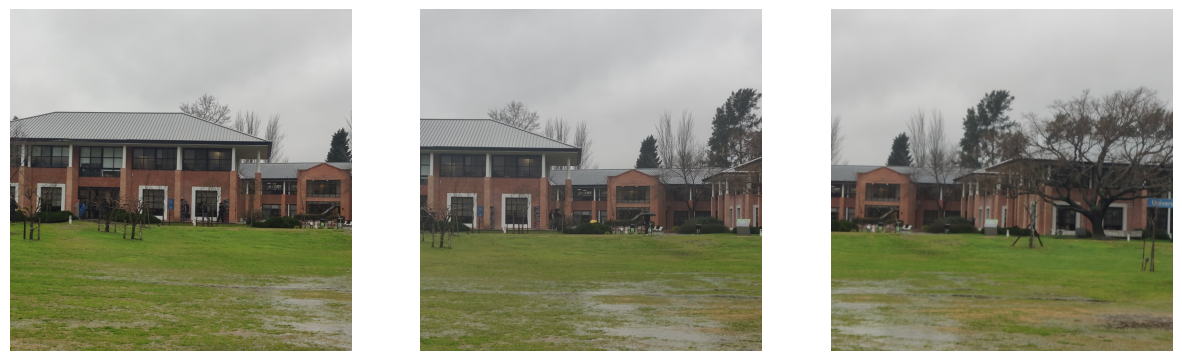

In [165]:


import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Ruta de la carpeta que contiene las imágenes
carpeta_imagenes = 'img'

udesa_0 = cv2.imread(os.path.join(carpeta_imagenes, 'udesa_0.jpg'))
udesa_1 = cv2.imread(os.path.join(carpeta_imagenes, 'udesa_1.jpg'))
udesa_2 = cv2.imread(os.path.join(carpeta_imagenes, 'udesa_2.jpg'))

#graficar las imagenes una al lado de la otra
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(udesa_0, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(udesa_1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(udesa_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Detección y descripición de características visuales


Imagen 0: 22105 keypoints detectados
Imagen 1: 14851 keypoints detectados
Imagen 2: 5364 keypoints detectados


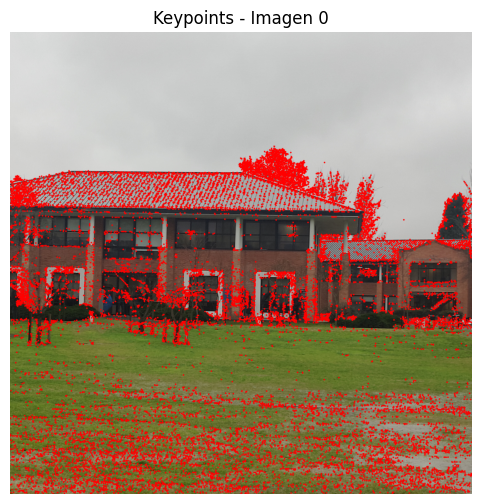

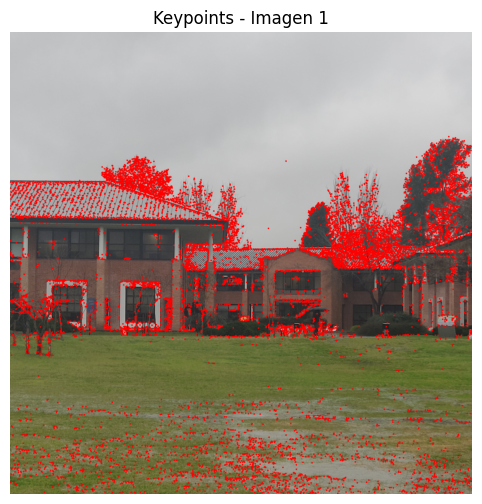

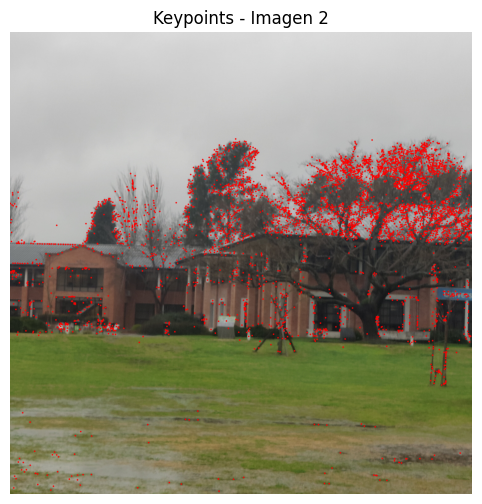

In [166]:
import cv2
import matplotlib.pyplot as plt

def detectar_descriptores(imagen, metodo="ORB", nfeatures=500):
    """
    Detecta keypoints y calcula descriptores de una imagen.
    
    Args:
        imagen (np.array): imagen cargada con cv2.imread
        metodo (str): "SIFT" o "ORB"
        nfeatures (int): cantidad máxima de features
    
    Returns:
        keypoints, descriptors
    """
    if metodo.upper() == "SIFT":
        detector = cv2.SIFT_create(nfeatures=nfeatures)
    elif metodo.upper() == "ORB":
        detector = cv2.ORB_create(nfeatures=nfeatures)
    else:
        raise ValueError("Método no soportado. Usar 'SIFT' u 'ORB'.")

    # detección + descripción en un solo paso
    keypoints, descriptors = detector.detectAndCompute(imagen, None)
    return keypoints, descriptors

def mostrar_keypoints(imagen, keypoints, titulo="Keypoints"):
    img_kp = imagen.copy()
    for kp in keypoints:
        x, y = map(int, kp.pt)
        cv2.circle(img_kp, (x, y), 5, (0,0,255), -1)  # círculos rojos
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis("off")
    plt.show()

# Detectar descriptores en cada imagen con ORB
kp0, des0 = detectar_descriptores(udesa_0, metodo="SIFT", nfeatures=50000)
kp1, des1 = detectar_descriptores(udesa_1, metodo="SIFT", nfeatures=50000)
kp2, des2 = detectar_descriptores(udesa_2, metodo="SIFT", nfeatures=50000)

print(f"Imagen 0: {len(kp0)} keypoints detectados")
print(f"Imagen 1: {len(kp1)} keypoints detectados")
print(f"Imagen 2: {len(kp2)} keypoints detectados")

# Mostrar imágenes con keypoints dibujados
mostrar_keypoints(udesa_0, kp0, "Keypoints - Imagen 0")
mostrar_keypoints(udesa_1, kp1, "Keypoints - Imagen 1")
mostrar_keypoints(udesa_2, kp2, "Keypoints - Imagen 2")


# 3.2.  Supresión de No Máxima Adaptativa

Imagen 0: 800 keypoints tras ANMS
Imagen 1: 800 keypoints tras ANMS
Imagen 2: 800 keypoints tras ANMS


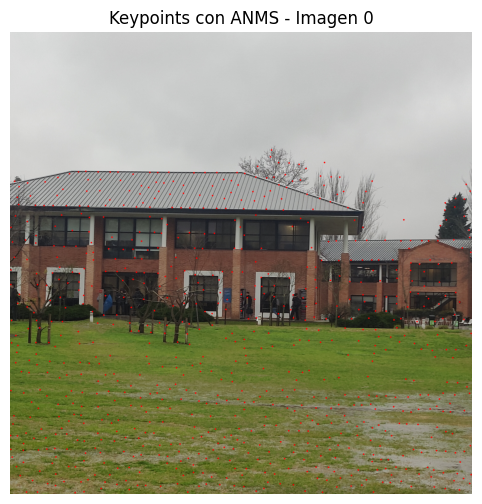

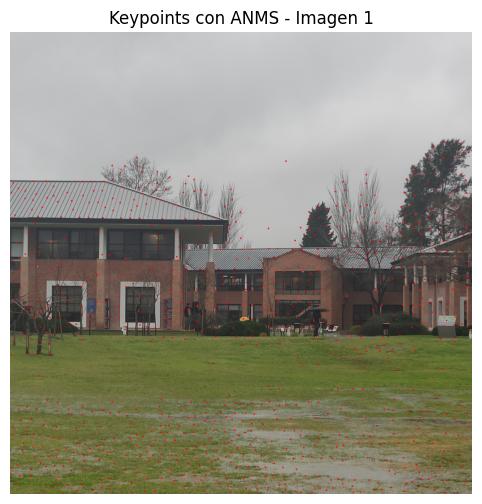

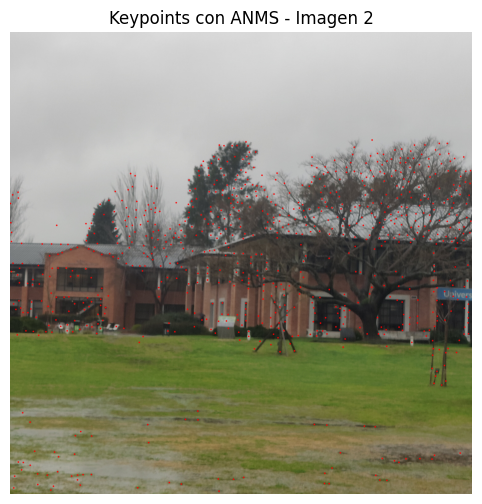

In [167]:

import numpy as np
from scipy.spatial import cKDTree

def aplicar_ANMS(keypoints, N=500):
    """
    ANMS rápido usando KD-Tree.
    
    Args:
        keypoints: lista de cv2.KeyPoint detectados
        N: cantidad máxima de puntos a conservar
    
    Returns:
        keypoints_filtrados: lista reducida de keypoints
    """
    if len(keypoints) <= N:
        return keypoints

    # Extraer coordenadas y respuestas
    coords = np.array([kp.pt for kp in keypoints])
    respuestas = np.array([kp.response for kp in keypoints])

    # Ordenar por respuesta descendente
    idx_sorted = np.argsort(-respuestas)
    coords_sorted = coords[idx_sorted]
    respuestas_sorted = respuestas[idx_sorted]

    # KDTree para búsquedas rápidas
    tree = cKDTree(coords_sorted)

    # Radios inicializados en infinito
    radios = np.full(len(coords_sorted), np.inf)

    # Para cada punto (menos fuerte), buscar el vecino más cercano más fuerte
    for i in range(1, len(coords_sorted)):
        # vecinos más fuertes son los anteriores en el orden
        d, j = tree.query(coords_sorted[i], k=i)  
        radios[i] = np.min(np.sum((coords_sorted[i] - coords_sorted[:i])**2, axis=1))

    # Ordenar por radio descendente
    idx_final = np.argsort(-radios)

    # Seleccionar top N
    seleccionados_idx = idx_final[:N]
    seleccionados = [keypoints[idx_sorted[i]] for i in seleccionados_idx]

    return seleccionados



# Aplicar ANMS para quedarnos con 800 bien distribuidos
kp0_anms = aplicar_ANMS(kp0, N=800)
kp1_anms = aplicar_ANMS(kp1, N=800)
kp2_anms = aplicar_ANMS(kp2, N=800)

print(f"Imagen 0: {len(kp0_anms)} keypoints tras ANMS")
print(f"Imagen 1: {len(kp1_anms)} keypoints tras ANMS")
print(f"Imagen 2: {len(kp2_anms)} keypoints tras ANMS")
# Visualizar resultado
mostrar_keypoints(udesa_0, kp0_anms, "Keypoints con ANMS - Imagen 0")
mostrar_keypoints(udesa_1, kp1_anms, "Keypoints con ANMS - Imagen 1")
mostrar_keypoints(udesa_2, kp2_anms, "Keypoints con ANMS - Imagen 2")


# ASOCIACIÓN DE CARACTERÍSTICAS

Imagen 0: 800 puntos tras ANMS
Imagen 1: 800 puntos tras ANMS
Imagen 2: 800 puntos tras ANMS
Matches entre 0 y 1: 67
Matches entre 2 y 1: 19


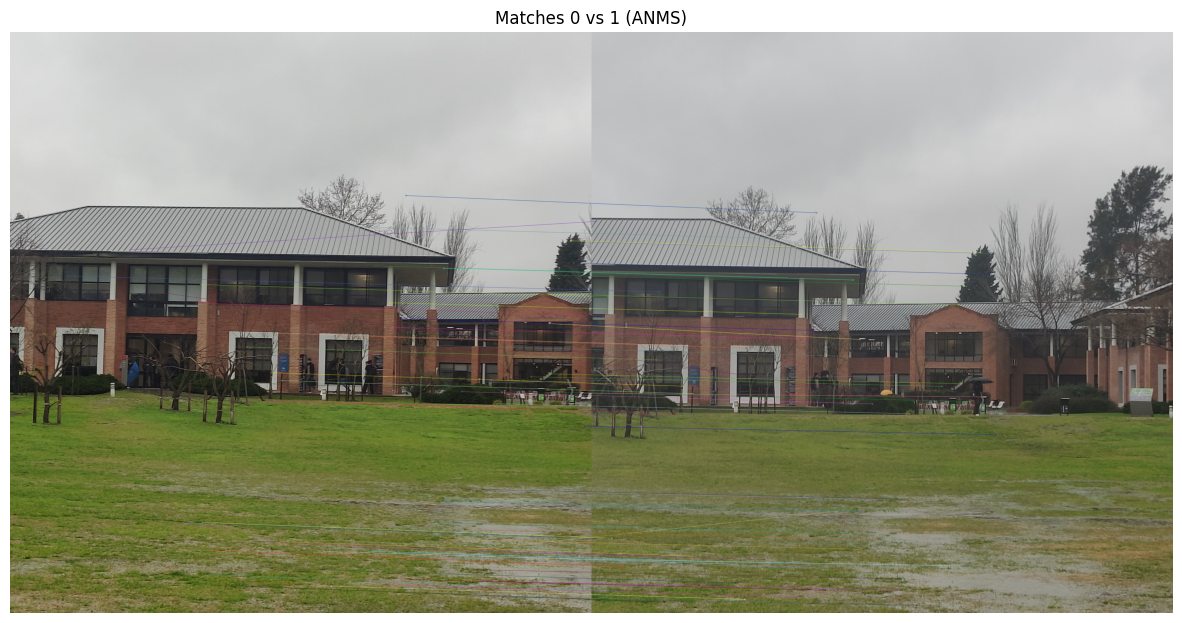

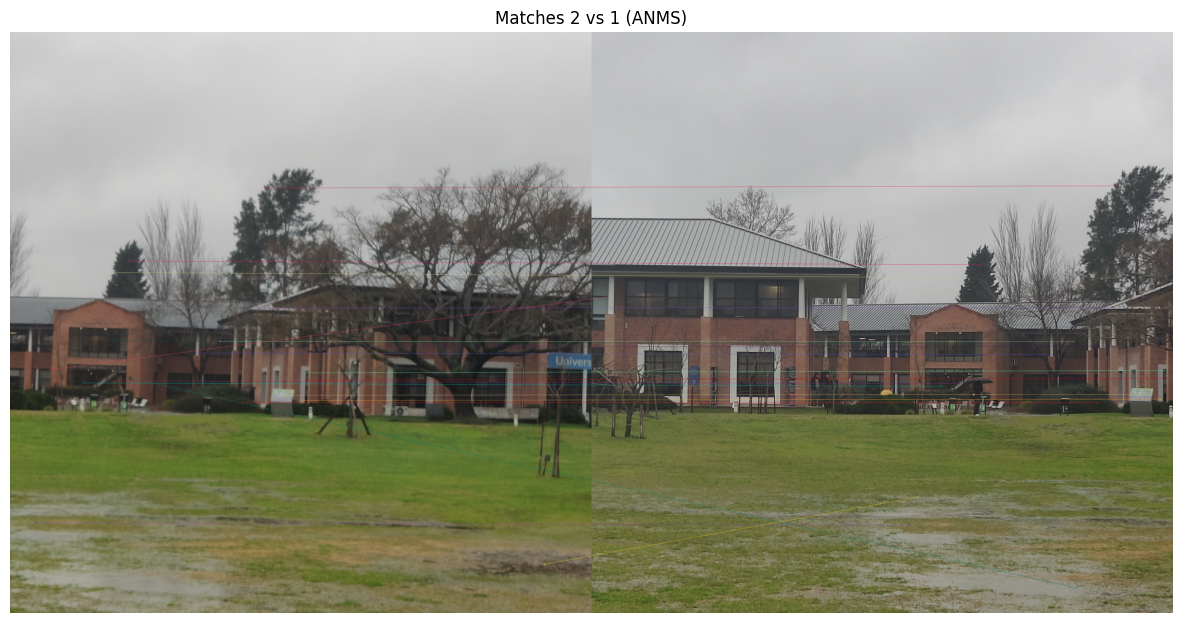

In [168]:
def filtrar_descriptores(keypoints, descriptores, keypoints_filtrados):
    """
    Retorna exactamente los descriptores correspondientes a los keypoints filtrados.
    """
    set_filtrados = set(keypoints_filtrados)  # conjunto de objetos KeyPoint
    kp_new, des_new = [], []
    for kp, des in zip(keypoints, descriptores):
        if kp in set_filtrados:
            kp_new.append(kp)
            des_new.append(des)
    return kp_new, np.array(des_new)

def match_features(desc1, desc2, metodo="SIFT", ratio=0.75,
                   use_ratio=True, use_cross_check=True):
    """
    Matching entre dos conjuntos de descriptores aplicando:
      - Lowe's ratio test
      - Cross-check
    Permite activar uno, otro, o ambos.
    """
    if metodo.upper() == "SIFT":
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    else:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # KNN Matching (2 vecinos)
    matches = bf.knnMatch(desc1, desc2, k=2)

    # Aplicar Lowe's ratio (si corresponde)
    if use_ratio:
        buenos = [m for m, n in matches if m.distance < ratio * n.distance]
    else:
        buenos = [m for m, _ in matches]  # tomar el primer vecino
       
    # Aplicar Cross-check (si corresponde)
    if use_cross_check:
        matches_12 = {(m.queryIdx, m.trainIdx) for m in buenos}
        matches_back = bf.knnMatch(desc2, desc1, k=2)

        if use_ratio:
            matches_21 = {
                (m.trainIdx, m.queryIdx)
                for m, n in matches_back if m.distance < ratio * n.distance
            }
        else:
            matches_21 = {(m.trainIdx, m.queryIdx) for m, _ in matches_back}

        interseccion = matches_12 & matches_21
        buenos = [m for m in buenos if (m.queryIdx, m.trainIdx) in interseccion]

    return buenos



def dibujar_matches(img1, kp1, img2, kp2, matches, max_matches, titulo="Matches"):
    """
    Visualiza las correspondencias.
    """
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:max_matches], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis("off")
    plt.show()

kp0_final, des0_final = filtrar_descriptores(kp0, des0, kp0_anms)
kp1_final, des1_final = filtrar_descriptores(kp1, des1, kp1_anms)
kp2_final, des2_final = filtrar_descriptores(kp2, des2, kp2_anms)


print(f"Imagen 0: {len(kp0_final)} puntos tras ANMS")
print(f"Imagen 1: {len(kp1_final)} puntos tras ANMS")
print(f"Imagen 2: {len(kp2_final)} puntos tras ANMS")

# Matching (usando la imagen 1 como "ancla")
matches01 = match_features(des0_final, des1_final, metodo="SIFT", ratio=0.75)
matches21 = match_features(des2_final, des1_final, metodo="SIFT", ratio=0.75)

print(f"Matches entre 0 y 1: {len(matches01)}")
print(f"Matches entre 2 y 1: {len(matches21)}")

# Visualizar algunos matches
dibujar_matches(udesa_0, kp0_final, udesa_1, kp1_final, matches01, 800, titulo="Matches 0 vs 1 (ANMS)")
dibujar_matches(udesa_2, kp2_final, udesa_1, kp1_final, matches21, 800, titulo="Matches 2 vs 1 (ANMS)")  

In [169]:
def homo(points_2d):
  n = points_2d.shape[0]
  z = np.ones((n, 1))
  return np.hstack((points_2d, z))

def cart(h_points):
  x = h_points[:, 0]
  y = h_points[:, 1]
  z = h_points[:, 2]
  return np.stack((x/z, y/z)).T



def apply_transform(shape, T):
  h_ori = homo(shape)
  h_dst = np.dot(T, h_ori.T)
  dst = cart(h_dst.T)
  return dst


def dlt(ori, dst):

  # Construct matrix A and vector b
  A = []
  b = []
  for i in range(4):
      x, y = ori[i]
      x_prima, y_prima = dst[i]
      A.append([-x, -y, -1, 0, 0, 0, x * x_prima, y * x_prima])
      A.append([0, 0, 0, -x, -y, -1, x * y_prima, y * y_prima])
      b.append(x_prima)
      b.append(y_prima)

  A = np.array(A)
  b = np.array(b)

  # resolvemos el sistema de ecuaciones A * h = b
  # el sistema es de 8x8, por lo que podemos resolverlo si A es inversible

  # resuelve el sistema de ecuaciones para encontrar los parámetros de H
  H = -np.linalg.solve(A, b)

  # agrega el elemento h_33
  H = np.hstack([H, [1]])

  # reorganiza H para formar la matrix en 3x3 to form the 3x3 homography matrix
  H = H.reshape(3, 3)

  return H

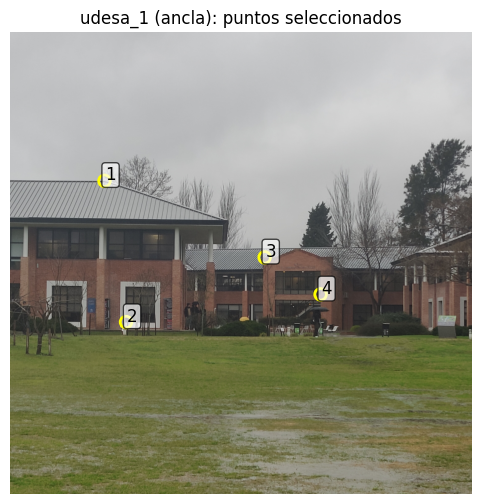

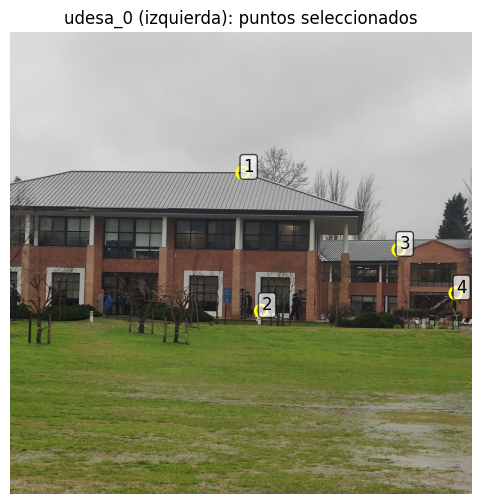

In [170]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# =========================
# Utilidades de visualización
# =========================
def show_points(img_bgr, pts, title=""):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.scatter(pts[:,0], pts[:,1], s=70, marker='o',
                facecolors='none', edgecolors='yellow', linewidths=2)
    for i, (x, y) in enumerate(pts):
        plt.text(x+5, y-5, f"{i+1}", fontsize=12, color='black',
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))
    plt.title(title); plt.axis('off'); plt.show()

def reproject_points(pts_src, H):
    pts_h = np.c_[pts_src, np.ones(len(pts_src))]
    proj = (H @ pts_h.T).T
    proj = proj[:, :2] / proj[:, [2]]
    return proj

def show_points_compare(img_bgr, pts_ref, pts_est, title=""):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.scatter(pts_ref[:,0], pts_ref[:,1], s=70, marker='o',
                facecolors='none', edgecolors='yellow', linewidths=2, label='Seleccionados')
    plt.scatter(pts_est[:,0], pts_est[:,1], s=50, marker='x',
                linewidths=2, label='Reproyectados')
    for (xr, yr), (xe, ye) in zip(pts_ref, pts_est):
        plt.plot([xr, xe], [yr, ye], linestyle='--', linewidth=1)
    for i, (x, y) in enumerate(pts_ref):
        plt.text(x+5, y-5, f"{i+1}", fontsize=12, color='black',
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))
    plt.title(title); plt.legend(loc='lower right'); plt.axis('off'); plt.show()

# =========================
# TUS PUNTOS
# =========================

ancla = np.array([
    (613, 966),
    (753, 1883),
    (1653, 1463),
    (2016, 1703)
])


izq = np.array([
    (1510, 913),
    (1630, 1810),
    (2523, 1413),
    (2893, 1696)
])


# =========================
# PLOTS
# =========================
# Mostrar puntos en cada imagen
show_points(udesa_1, ancla, title="udesa_1 (ancla): puntos seleccionados")
show_points(udesa_0, izq, title="udesa_0 (izquierda): puntos seleccionados")




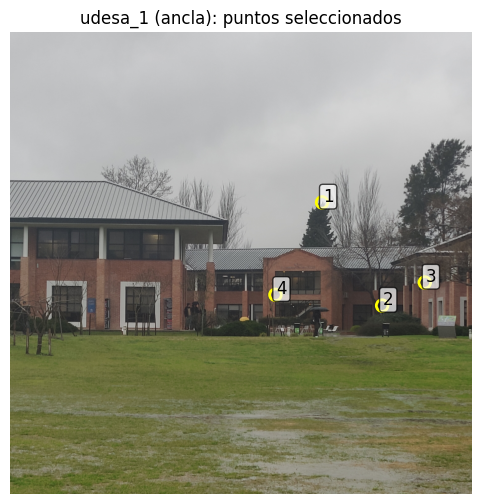

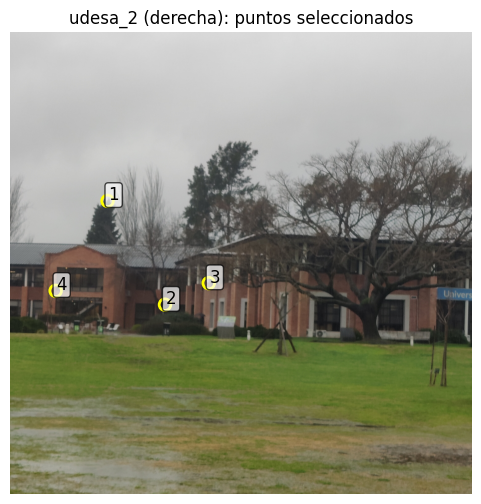

In [171]:
ancla2 = np.array([
    (2026, 1106),
    (2416, 1776),
    (2693, 1626),
    (1723, 1706)
])


der = np.array([
    (633, 1096),
    (1006, 1770),
    (1290, 1630),
    (296, 1680)
])

show_points(udesa_1, ancla2, title="udesa_1 (ancla): puntos seleccionados")
show_points(udesa_2, der, title="udesa_2 (derecha): puntos seleccionados")

In [172]:
import numpy as np
import cv2  # solo para la homografía final (sin RANSAC)

# -----------------------------------
# 2) Utilidades de error / degenerado
# -----------------------------------
def reprojection_errors(H, pts_src, pts_dst):
    """
    Error de reproyección unidireccional (a la imagen destino), en píxeles.
    e_i = || dst_i - norm(H * src_i) ||_2
    """
    n = len(pts_src)
    src_h = np.c_[pts_src, np.ones(n)]
    proj  = (H @ src_h.T).T
    proj  = proj[:, :2] / proj[:, [2]]
    return np.linalg.norm(pts_dst - proj, axis=1)

def symmetric_transfer_error(H, pts_src, pts_dst):
    """
    Error simétrico: e = ||x' - Hx|| + ||x - H^{-1}x'||.
    Un poco más caro pero más estable.
    """
    e1 = reprojection_errors(H, pts_src, pts_dst)
    try:
        Hinv = np.linalg.inv(H)
        e2 = reprojection_errors(Hinv, pts_dst, pts_src)
    except np.linalg.LinAlgError:
        e2 = np.full_like(e1, np.inf)
    return e1 + e2

def _non_degenerate(sample_src, sample_dst, tol=1e-3):
    """
    Evita muestras degeneradas (puntos casi colineales).
    Chequea rango de [x,y,1]^T >= 2.8 aprox tanto en src como dst.
    """
    def rank3(pts):
        M = np.c_[pts, np.ones(len(pts))]
        return np.linalg.matrix_rank(M, tol)
    return rank3(sample_src) >= 3 and rank3(sample_dst) >= 3

# -----------------------------
# 3) RANSAC para homografía (sin OpenCV)
# -----------------------------
def ransac_homography(pts_src, pts_dst, thresh=3.0, max_trials=5000,
                      confidence=0.999, use_symmetric_error=True, seed=None):
    """
    Implementación RANSAC:
    - Selecciona 4 pares aleatorios
    - Estima H con DLT normalizado
    - Cuenta inliers (error < thresh)
    - Guarda el mejor conjunto
    - Recalcula H con TODOS los inliers (DLT) para devolverla (sin OpenCV)

    Devuelve: H_best (numpy 3x3), inlier_mask (bool de tamaño N)
    """
    assert pts_src.shape == pts_dst.shape and pts_src.shape[0] >= 4
    N = len(pts_src)
    rng = np.random.default_rng(seed)

    best_inliers = None
    best_H = None
    best_num = 0
    best_err_sum = np.inf

    s = 4  # tamaño de muestra mínima
    log1p = np.log  # alias

    # número de intentos dinámico (se puede acortar si mejora la razón de inliers)
    trials = max_trials
    i = 0
    while i < trials:
        i += 1
        # muestreo sin reemplazo de 4 índices
        idx = rng.choice(N, size=s, replace=False)
        sample_src = pts_src[idx]
        sample_dst = pts_dst[idx]

        if not _non_degenerate(sample_src, sample_dst):
            continue

        # H candidata
        try:
            H = dlt(sample_src, sample_dst)
        except np.linalg.LinAlgError:
            continue

        # errores y máscara de inliers
        if use_symmetric_error:
            errs = symmetric_transfer_error(H, pts_src, pts_dst)
        else:
            errs = reprojection_errors(H, pts_src, pts_dst)

        inliers = errs < thresh
        num_inl = int(inliers.sum())

        if num_inl > best_num or (num_inl == best_num and errs[inliers].sum() < best_err_sum):
            best_num = num_inl
            best_inliers = inliers
            best_err_sum = errs[inliers].sum()
            best_H = H

            # actualizar número esperado de iteraciones (parada temprana)
            w = max(1e-6, num_inl / N)
            num = 1 - confidence
            den = 1 - w ** s
            if den <= 1e-12:
                trials = i  # ya está
            else:
                trials = min(trials, int(np.ceil(log1p(num) / log1p(den))))
                trials = max(trials, i + 1)

    # homografía final con TODOS los inliers (por DLT)
    if best_inliers is None or best_num < 4:
        raise RuntimeError("RANSAC no encontró un modelo válido (revisar correspondencias/umbral).")

    H_final = dlt(pts_src[best_inliers], pts_dst[best_inliers])
    return H_final, best_inliers

# --------------------------------------------
# 4) Cálculo final con OpenCV (opcional, pedido)
# --------------------------------------------
def homography_final_opencv(pts_src, pts_dst, inlier_mask):
    """
    Homografía final usando SOLO los inliers, con cv2.findHomography sin RANSAC.
    (Esto es lo permitido por el enunciado.)
    """
    H, _ = cv2.findHomography(pts_src[inlier_mask], pts_dst[inlier_mask], method=0)
    # Normalizamos por si acaso
    return H / H[2, 2]


In [173]:
#calculo de las homografias con dlt
H01_manual = dlt(izq, ancla)
H02_manual = dlt(der, ancla2)

#normalizar
H01_manual = H01_manual / H01_manual[2, 2]
H02_manual = H02_manual / H02_manual[2, 2]

   

[INFO] Canvas 18588x13560 demasiado grande. Escalando por 0.315...


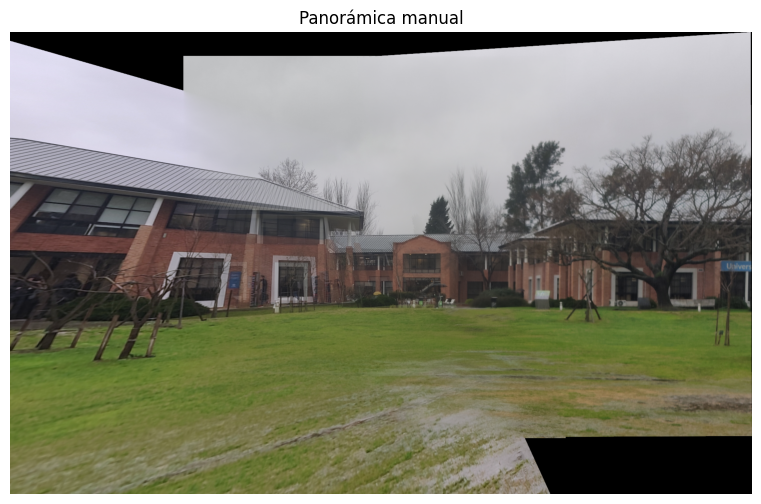

In [174]:
import cv2
import numpy as np

def warp_blend_panorama(img_anchor, img_left=None, img_right=None,
                             H_left_to_anchor=None, H_right_to_anchor=None,
                             exposure_comp=True, max_canvas_px=25_000_000,
                             max_scale_ratio=4.0,  # cuánto permitimos que “crezca” el área proyectada
                             verbose=True):
    """
    Stitching robusto contra homografías malas (pocos matches):
    - Valida cada H (no finitos / área proyectada >> área fuente).
    - Dimensión del canvas con SOLO las H válidas; si ninguna, canvas = ancla.
    - Warps + blending (distance transform) + recorte.
    - Opción de compensación de exposición.

    Si una H es inválida, esa imagen se saltea (se pega lo demás).
    """

    def _corners(w, h):
        return np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)

    def _quad_area(quad_xy):
        # área (módulo) del polígono convexo de 4 puntos (en orden arbitrario)
        q = quad_xy.reshape(-1,2)
        x, y = q[:,0], q[:,1]
        return 0.5 * abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

    def _project_corners_ok(img, H, area_ratio_cap=max_scale_ratio):
        """Chequea que H sea razonable para este img: esquinas finitas + escala de área acotada."""
        h, w = img.shape[:2]
        src_area = float(w*h) + 1e-6
        try:
            proj = cv2.perspectiveTransform(_corners(w, h), H)  # (4,1,2)
        except Exception:
            return False, None, None
        proj2 = proj.reshape(-1,2)
        if not np.isfinite(proj2).all():
            return False, None, None
        area_proj = _quad_area(proj2) + 1e-6
        scale = np.sqrt(area_proj / src_area)  # escala lineal efectiva
        if scale > area_ratio_cap or scale < 1.0/area_ratio_cap:
            return False, proj2, scale
        return True, proj2, scale

    # ---------------- 1) Armar lista de imágenes y validar H ----------------
    hA, wA = img_anchor.shape[:2]
    items = [("anchor", img_anchor, np.eye(3, dtype=np.float64), True, _corners(wA, hA).reshape(-1,2), 1.0)]

    if img_left is not None and H_left_to_anchor is not None:
        okL, projL, scaleL = _project_corners_ok(img_left, H_left_to_anchor, max_scale_ratio)
        items.append(("left", img_left, H_left_to_anchor, okL, projL, scaleL))

    if img_right is not None and H_right_to_anchor is not None:
        okR, projR, scaleR = _project_corners_ok(img_right, H_right_to_anchor, max_scale_ratio)
        items.append(("right", img_right, H_right_to_anchor, okR, projR, scaleR))

    # Canvas solo con las que sean "ok" (y siempre ancla)
    all_pts = [items[0][4]]  # esquinas ancla
    bad_names = []
    for name, img, H, ok, proj, scale in items[1:]:
        if ok and proj is not None:
            all_pts.append(proj)
        else:
            bad_names.append(name)

    all_pts = np.vstack(all_pts)
    xmin, ymin = np.floor(all_pts.min(axis=0)).astype(np.int64)
    xmax, ymax = np.ceil (all_pts.max(axis=0)).astype(np.int64)

    tx, ty = int(-xmin), int(-ymin)
    T = np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float64)
    W, H = int(xmax - xmin), int(ymax - ymin)

    if verbose and bad_names:
        print(f"[AVISO] Se omitirá del canvas (H sospechosa): {', '.join(bad_names)}")

    # Control de tamaño total del canvas
    if (W*H) > max_canvas_px:
        # auto-escala todo para caber
        s = float((max_canvas_px / (W*H))**0.5)
        if verbose:
            print(f"[INFO] Canvas {W}x{H} demasiado grande. Escalando por {s:.3f}...")
        S = np.array([[s,0,0],[0,s,0],[0,0,1]], dtype=np.float64)

        def _rs(img):
            return cv2.resize(img, (int(img.shape[1]*s), int(img.shape[0]*s)), interpolation=cv2.INTER_AREA)

        # re-escalar imágenes
        img_anchor = _rs(img_anchor)
        new_items = [("anchor", img_anchor, np.eye(3), True, _corners(img_anchor.shape[1], img_anchor.shape[0]).reshape(-1,2), 1.0)]
        for (name, img, H, ok, proj, scale) in items[1:]:
            if img is None or H is None:
                continue
            img2 = _rs(img)
            # ajustar H: S * H * S^{-1}
            H2 = S @ H @ np.linalg.inv(S)
            ok2, proj2, scale2 = _project_corners_ok(img2, H2, max_scale_ratio)
            new_items.append((name, img2, H2, ok2, proj2, scale2))
        items = new_items

        # recomputar canvas con escalas
        all_pts = [items[0][4]]
        bad_names = []
        for name, img, H, ok, proj, scale in items[1:]:
            if ok and proj is not None:
                all_pts.append(proj)
            else:
                bad_names.append(name)
        all_pts = np.vstack(all_pts)
        xmin, ymin = np.floor(all_pts.min(axis=0)).astype(np.int64)
        xmax, ymax = np.ceil (all_pts.max(axis=0)).astype(np.int64)
        tx, ty = int(-xmin), int(-ymin)
        T = np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float64)
        W, H = int(xmax - xmin), int(ymax - ymin)
        if verbose and bad_names:
            print(f"[AVISO] (post-escala) Se omitirá del canvas: {', '.join(bad_names)}")

    # ---------------- 2) Warpear SOLO las válidas (ancla siempre) ----------------
    W, H = int(W), int(H)
    warped, masks = [], []

    # ancla
    wA_img = cv2.warpPerspective(items[0][1], T, (W, H), flags=cv2.INTER_LINEAR,  borderValue=0)
    mA     = cv2.warpPerspective(np.ones(items[0][1].shape[:2], np.uint8),
                                 T, (W, H), flags=cv2.INTER_NEAREST, borderValue=0)
    warped.append(wA_img); masks.append(mA)

    # resto
    for (name, img, Hmat, ok, proj, scale) in items[1:]:
        if not ok:
            if verbose:
                print(f"[SKIP] '{name}' no se warpea (H inválida: escala≈{scale if scale is not None else 'nan'})")
            continue
        H_adj = (T @ Hmat).astype(np.float64)
        wimg  = cv2.warpPerspective(img,   H_adj, (W, H), flags=cv2.INTER_LINEAR,  borderValue=0)
        msrc  = cv2.warpPerspective(np.ones(img.shape[:2], np.uint8),
                                    H_adj, (W, H), flags=cv2.INTER_NEAREST, borderValue=0)
        warped.append(wimg); masks.append(msrc)

    # Si sólo quedó ancla, devolverla
    if len(warped) == 1:
        return warped[0]

    # ---------------- 3) Compensación de exposición simple (contra ancla) ----------------
    if exposure_comp:
        base = warped[0]; mbase = masks[0]
        ker = np.ones((3,3), np.uint8)
        mbase_c = cv2.morphologyEx(mbase, cv2.MORPH_CLOSE, ker, iterations=1)

        for i in range(1, len(warped)):
            imgX, mX = warped[i], masks[i]
            mX_c = cv2.morphologyEx(mX, cv2.MORPH_CLOSE, ker, iterations=1)
            ov = (mbase_c==1) & (mX_c==1)
            if not np.any(ov): 
                continue
            X = imgX.astype(np.float32)
            for c in range(3):
                b_mean = base[...,c][ov].mean() + 1e-6
                x_mean = X   [...,c][ov].mean() + 1e-6
                g = np.clip(b_mean/x_mean, 0.6, 1.6)
                X[...,c] = np.clip(X[...,c]*g, 0, 255)
            warped[i] = X.astype(np.uint8)

    # ---------------- 4) Blending DT + recorte ----------------
    Hh, Ww = masks[0].shape
    acc  = np.zeros((Hh, Ww, 3), np.float32)
    wsum = np.zeros((Hh, Ww),    np.float32)
    ker = np.ones((3,3), np.uint8)

    for img, m in zip(warped, masks):
        m_clean = cv2.morphologyEx(m, cv2.MORPH_CLOSE, ker, iterations=1)
        dt_full = cv2.distanceTransform(m_clean, cv2.DIST_L2, 5).astype(np.float32)
        dt = np.zeros_like(dt_full, np.float32)
        dt[m_clean > 0] = dt_full[m_clean > 0]
        acc  += img.astype(np.float32) * dt[..., None]
        wsum += dt

    wsum[wsum == 0] = 1.0
    pano = (acc / wsum[..., None]).astype(np.uint8)

    union = np.zeros_like(masks[0], np.uint8)
    for m in masks:
        union |= (m > 0).astype(np.uint8)
    union = cv2.morphologyEx(union, cv2.MORPH_CLOSE, ker, iterations=1)
    ys, xs = np.where(union > 0)
    if len(xs) and len(ys):
        pano = pano[ys.min():ys.max()+1, xs.min():xs.max()+1]

    return pano



pano_manual = warp_blend_panorama(udesa_1, udesa_0, udesa_2, H01_manual, H02_manual)
plt.figure(figsize=(10,6))
plt.title("Panorámica manual")
plt.imshow(cv2.cvtColor(pano_manual, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()

In [175]:
# ---------- IZQUIERDA -> ANCLA (0 -> 1) ----------
pts01_src = np.float32([kp0_final[m.queryIdx].pt for m in matches01])  # coords en udesa_0
pts01_dst = np.float32([kp1_final[m.trainIdx].pt for m in matches01])  # coords en udesa_1 (ancla)

print("pts01_src:", pts01_src.shape, " pts01_dst:", pts01_dst.shape)  # debería ser (N, 2)

assert pts01_src.shape == pts01_dst.shape and pts01_src.shape[0] >= 4, \
    "Se necesitan >=4 correspondencias y misma forma Nx2"

H01_keypoints, inliers3 = ransac_homography(
    pts01_src, pts01_dst,
    thresh=5.0, max_trials=5000, confidence=0.999,
    use_symmetric_error=True, seed=42
)

# (opcional) refinar con OpenCV sin RANSAC:
# H3 = homography_final_opencv(pts01_src, pts01_dst, inliers3)


# ---------- DERECHA -> ANCLA (2 -> 1) ----------
pts21_src = np.float32([kp2_final[m.queryIdx].pt for m in matches21])  # coords en udesa_2
pts21_dst = np.float32([kp1_final[m.trainIdx].pt for m in matches21])  # coords en udesa_1 (ancla)

print("pts21_src:", pts21_src.shape, " pts21_dst:", pts21_dst.shape)  # (N, 2)

assert pts21_src.shape == pts21_dst.shape and pts21_src.shape[0] >= 4, \
    "Se necesitan >=4 correspondencias y misma forma Nx2"

H02_keypoints, inliers4 = ransac_homography(
    pts21_src, pts21_dst,
    thresh=5.0, max_trials=5000, confidence=0.999,
    use_symmetric_error=True, seed=42
)

# (opcional) refinar con OpenCV sin RANSAC:
# H4 = homography_final_opencv(pts21_src, pts21_dst, inliers4)


pts01_src: (67, 2)  pts01_dst: (67, 2)
pts21_src: (19, 2)  pts21_dst: (19, 2)


[AVISO] Se omitirá del canvas (H sospechosa): right
[SKIP] 'right' no se warpea (H inválida: escala≈0.007542472332715988)


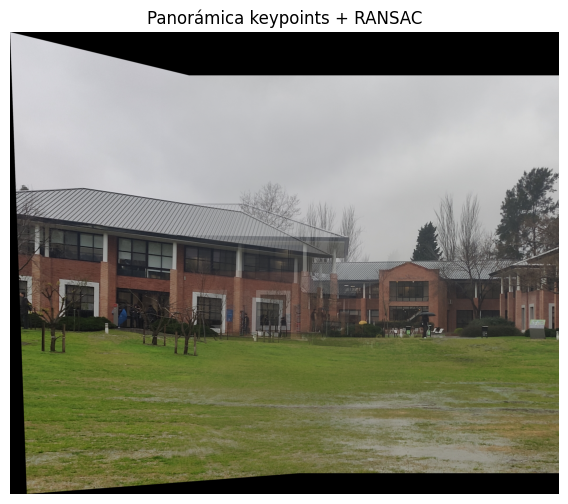

In [176]:
pano_keypoint = warp_blend_panorama(udesa_1, udesa_0, udesa_2, H01_keypoints, H02_keypoints)
plt.figure(figsize=(10,6))
plt.title("Panorámica keypoints + RANSAC")
plt.imshow(cv2.cvtColor(pano_keypoint, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()